# San Francisco Crime Classification with 5 Features

Data: https://www.kaggle.com/c/sf-crime/data

Data fields
- Dates - timestamp of the crime incident
- Category - category of the crime incident (only in train.csv). **This is the target variable you are going to predict.**
- Descript - detailed description of the crime incident (only in train.csv)
- DayOfWeek - the day of the week
- PdDistrict - name of the Police Department District
- Resolution - how the crime incident was resolved (only in train.csv)
- Address - the approximate street address of the crime incident 
- X - Longitude
- Y - Latitude

San Francisco Crime Classification EDA and Basic Modeling을 먼저 보고 본 notebook을 참고해주시기 바랍니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [5]:
train.shape, test.shape

((878049, 9), (884262, 7))

## Longtitude, Latitude Boxplot

In [6]:
# 경도(Longtitude)
train.X.min(), train.X.max()

(-122.51364206429, -120.5)

In [7]:
# 위도 (Latitude)
train.Y.min(), train.Y.max()

(37.7078790224135, 90.0)

In [8]:
test.X.min(), test.X.max()

(-122.51364206429, -120.5)

In [9]:
test.Y.min(), test.Y.max()

(37.7078790224135, 90.0)

37.828495, -122.425863 / 37.825059, -122.420260

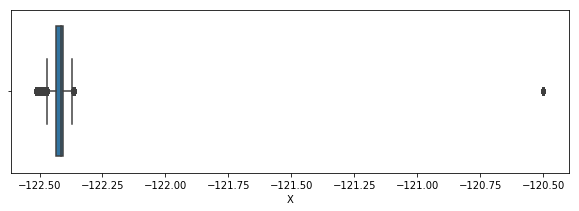

In [10]:
plt.figure(figsize=(10,3))
sns.boxplot(x='X', data=train);

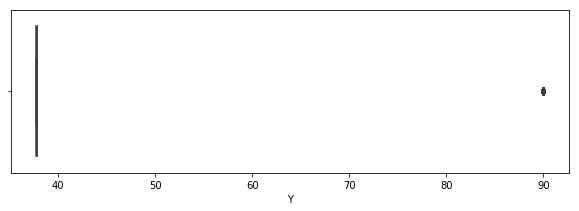

In [11]:
plt.figure(figsize=(10,3))
sns.boxplot(x='Y', data=train);

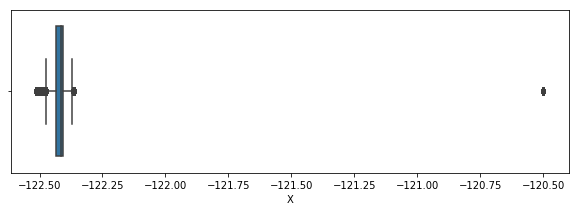

In [12]:
plt.figure(figsize=(10,3))
sns.boxplot(x='X', data=test);

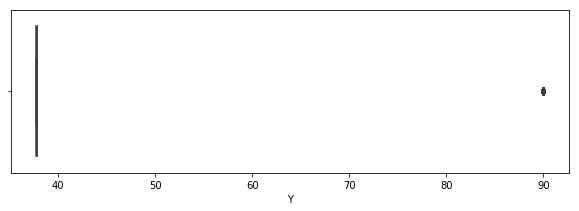

In [13]:
plt.figure(figsize=(10,3))
sns.boxplot(x='Y', data=test);

## Without Outlier

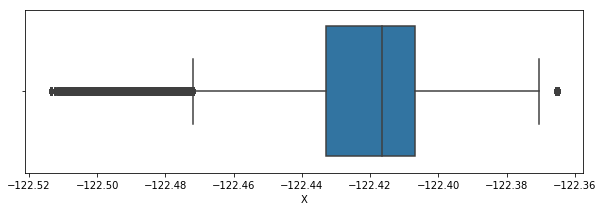

In [14]:
plt.figure(figsize=(10,3))
sns.boxplot(x='X', data=train[train.X < -122]);

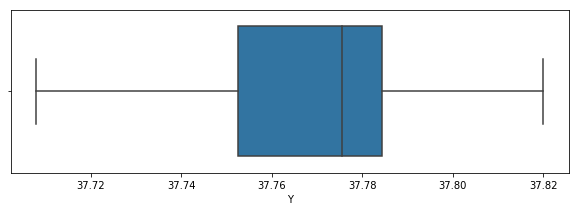

In [15]:
plt.figure(figsize=(10,3))
sns.boxplot(x='Y', data=train[train.Y < 80]);

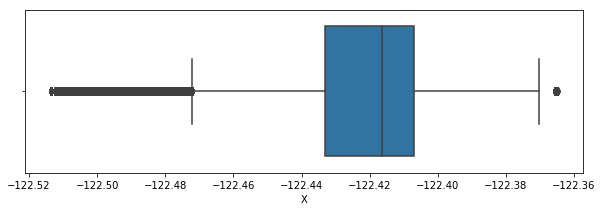

In [16]:
plt.figure(figsize=(10,3))
sns.boxplot(x='X', data=test[test.X < -122]);

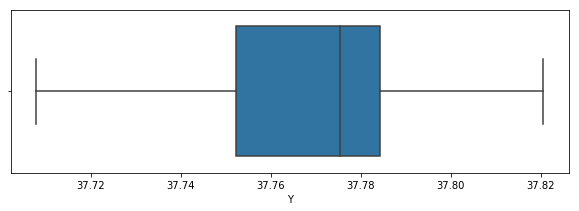

In [17]:
plt.figure(figsize=(10,3))
sns.boxplot(x='Y', data=test[test.Y < 80]);

In [18]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


## Dates Split
년, 월, 일, 시간으로 나누어 DataFrame에 저장합니다.

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


우선, Dates의 type을 datetime으로 바꿔줍니다.

In [20]:
train.Dates = pd.to_datetime(train.Dates)
test.Dates = pd.to_datetime(test.Dates)

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB


년, 월, 일, 시간 순으로 dataframe에 저장해줍니다.

In [22]:
train['Year'] = train['Dates'].dt.year
train['Month'] = train['Dates'].dt.month
train['Day'] = train['Dates'].dt.day
train['Hour'] = train['Dates'].dt.hour

In [23]:
test['Year'] = test['Dates'].dt.year
test['Month'] = test['Dates'].dt.month
test['Day'] = test['Dates'].dt.day
test['Hour'] = test['Dates'].dt.hour

## Convert Numeric Variables to Categorical Variables

In [24]:
X_bins = [-123, -122.5, -122.48, -122.46, -122.44, -122.43, -122.42, -122.41, -122.40, -122.38, -122.36, -120]
Y_bins = [37, 37.72, 37.74, 37.76, 37.77, 37.78, 37.80, 37.82, 91]
X_labels = [1, 2, 3 ,4 ,5, 6, 7, 8, 9, 10, 11]
Y_labels = [1, 2, 3 ,4 ,5, 6, 7, 8]

train_X_cats = pd.cut(train.X, X_bins, labels=X_labels)
train_Y_cats = pd.cut(train.Y, Y_bins, labels=Y_labels)

test_X_cats = pd.cut(test.X, X_bins, labels=X_labels)
test_Y_cats = pd.cut(test.Y, Y_bins, labels=Y_labels)

In [25]:
train['X_cats'] = train_X_cats
train['Y_cats'] = train_Y_cats
test['X_cats'] = test_X_cats
test['Y_cats'] = test_Y_cats

In [26]:
test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y,Year,Month,Day,Hour,X_cats,Y_cats
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051,2015,5,10,23,9,2
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432,2015,5,10,23,9,2
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212,2015,5,10,23,6,6
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23,5,2
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23,5,2


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 15 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
Year          878049 non-null int64
Month         878049 non-null int64
Day           878049 non-null int64
Hour          878049 non-null int64
X_cats        878049 non-null category
Y_cats        878049 non-null category
dtypes: category(2), datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 88.8+ MB


X_cats와 Y_cats가 Cateogry type이므로 int타입으로 바꿔줍니다.

In [28]:
train['X_cats'] = train['X_cats'].astype('int8')
train['Y_cats'] = train['Y_cats'].astype('int8')
test['X_cats'] = test['X_cats'].astype('int8')
test['Y_cats'] = test['Y_cats'].astype('int8')

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 15 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
Year          878049 non-null int64
Month         878049 non-null int64
Day           878049 non-null int64
Hour          878049 non-null int64
X_cats        878049 non-null int8
Y_cats        878049 non-null int8
dtypes: datetime64[ns](1), float64(2), int64(4), int8(2), object(6)
memory usage: 88.8+ MB


## Label Encoding

In [30]:
# Catergory Encoding
cat_encoder = LabelEncoder()
train['Category_encoded'] = cat_encoder.fit_transform(train['Category'])

In [31]:
# DayOfWeek Encoding
day_encoder = LabelEncoder()
train['DayOfWeek_encoded'] = day_encoder.fit_transform(train['DayOfWeek'])
test['DayOfWeek_encoded'] = day_encoder.fit_transform(test['DayOfWeek'])

In [32]:
# Descript Encoding
descript_encoder = LabelEncoder()
train['Descript_encoded'] = descript_encoder.fit_transform(train['Descript'])

In [33]:
# PdDistrict Encoding
pdDistrict_encoder = LabelEncoder()
train['PdDistrict_encoded'] = pdDistrict_encoder.fit_transform(train['PdDistrict'])
test['PdDistrict_encoded'] = pdDistrict_encoder.fit_transform(test['PdDistrict'])

In [34]:
# Address Encoding
address_encoder = LabelEncoder()
train['Address_encoded'] = address_encoder.fit_transform(train['Address'])
test['Address_encoded'] = address_encoder.fit_transform(test['Address'])

In [35]:
train.head(1)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day,Hour,X_cats,Y_cats,Category_encoded,DayOfWeek_encoded,Descript_encoded,PdDistrict_encoded,Address_encoded
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,6,5,37,6,866,4,19790


In [36]:
test.head(1)

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y,Year,Month,Day,Hour,X_cats,Y_cats,DayOfWeek_encoded,PdDistrict_encoded,Address_encoded
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051,2015,5,10,23,9,2,3,0,6407


## Modeling

In [40]:
X = train[['Year', 'Month', 'Hour', 'X_cats', 'Y_cats', 'DayOfWeek_encoded', 'PdDistrict_encoded', 'Address_encoded']]
y = train['Category_encoded']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
xgb_model = XGBClassifier(
    min_child_weight=300,
    n_estimators=1000,
    seed=42)

xgb_model.fit(X_train, 
              y_train, 
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              verbose=True, 
              early_stopping_rounds=10)

[0]	validation_0-merror:0.767426	validation_1-merror:0.765317
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.765942	validation_1-merror:0.764729
[2]	validation_0-merror:0.765473	validation_1-merror:0.764083
[3]	validation_0-merror:0.763884	validation_1-merror:0.762591
[4]	validation_0-merror:0.762351	validation_1-merror:0.761399
[5]	validation_0-merror:0.761998	validation_1-merror:0.760925
[6]	validation_0-merror:0.761741	validation_1-merror:0.760803
[7]	validation_0-merror:0.761369	validation_1-merror:0.760708
[8]	validation_0-merror:0.760519	validation_1-merror:0.759513
[9]	validation_0-merror:0.760433	validation_1-merror:0.759615
[10]	validation_0-merror:0.759818	validation_1-merror:0.758928
[11]	validation_0-merror:0.759958	validation_1-merror:0.758913
[12]	validation_0-merror:0.759826	validation_1-merror:0.758605
[13]	validation_0-merror:0.7

[128]	validation_0-merror:0.744498	validation_1-merror:0.743367
[129]	validation_0-merror:0.744357	validation_1-merror:0.743253
[130]	validation_0-merror:0.744305	validation_1-merror:0.743283
[131]	validation_0-merror:0.744279	validation_1-merror:0.743105
[132]	validation_0-merror:0.744096	validation_1-merror:0.742934
[133]	validation_0-merror:0.744077	validation_1-merror:0.7429
[134]	validation_0-merror:0.74397	validation_1-merror:0.742847
[135]	validation_0-merror:0.743882	validation_1-merror:0.742741
[136]	validation_0-merror:0.743778	validation_1-merror:0.742722
[137]	validation_0-merror:0.743628	validation_1-merror:0.74268
[138]	validation_0-merror:0.743553	validation_1-merror:0.74257
[139]	validation_0-merror:0.743509	validation_1-merror:0.742433
[140]	validation_0-merror:0.743462	validation_1-merror:0.742369
[141]	validation_0-merror:0.743359	validation_1-merror:0.742338
[142]	validation_0-merror:0.743088	validation_1-merror:0.742061
[143]	validation_0-merror:0.742907	validation

[257]	validation_0-merror:0.735981	validation_1-merror:0.735528
[258]	validation_0-merror:0.735923	validation_1-merror:0.735425
[259]	validation_0-merror:0.735973	validation_1-merror:0.735391
[260]	validation_0-merror:0.735893	validation_1-merror:0.735353
[261]	validation_0-merror:0.735794	validation_1-merror:0.735243
[262]	validation_0-merror:0.735761	validation_1-merror:0.735201


In [ ]:
X_test = test[['Year', 'Month', 'Hour', 'X_cats', 'Y_cats', 'DayOfWeek_encoded', 'PdDistrict_encoded', 'Address_encoded']]
y_test = xgb_model.predict(X_test)

In [ ]:
submission = pd.read_csv('./data/sampleSubmission.csv')
submission.head(2)

Sample Submission의 WARRANTS 열이 모두 1로 되어 있어 default인 0으로 변경해줍니다.

In [ ]:
submission.WARRANTS = 0
submission.head(2)

submission의 모든 열이 0으로 되어 있으므로, loop를 돌며 Category에 해당하면 해당 열에 1을 입력해줍니다.

In [ ]:
for index, row in submission.iterrows():
    # 맨 앞에 ID가 있으므로 +1을 해야함
    category_index = y_test[index]+1
    row.iloc[category_index] = 1

In [ ]:
submission.to_csv('submission_second.csv', index=False)